# ECG Arrhythmia Dataset Analysis


**Dataset:** https://physionet.org/content/ecg-arrhythmia/1.0.0/

**Key Analyses:**
1. Record duration verification
2. AFib vs Normal distribution
3. Overall rhythm distribution
4. Sinus Rhythm (SR) ECG visualization

In [3]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
from collections import Counter
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Dataset Setup

**Instructions:**
1. Download the dataset from PhysioNet: https://physionet.org/content/ecg-arrhythmia/1.0.0/
2. Extract the files
3. Update the `DATA_PATH` variable below to point to your local copy

In [4]:

DATA_PATH = 'C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/data/ecg-arrhythmia/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0'

# Paths to important files
WFDB_RECORDS_PATH = os.path.join(DATA_PATH, 'WFDBRecords')
RECORDS_FILE = os.path.join(DATA_PATH, 'RECORDS')
CONDITIONS_FILE = os.path.join(DATA_PATH, 'ConditionNames_SNOMED-CT.csv')

# Check if paths exist
if os.path.exists(DATA_PATH):
    print(f"✓ Dataset path found: {DATA_PATH}")
else:
    print(f"✗ Dataset path not found. Please update DATA_PATH variable.")
    print(f"  Current path: {DATA_PATH}")

✓ Dataset path found: C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/data/ecg-arrhythmia/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0


## 2. Load Record Metadata

We'll scan all ECG records to extract:
- Duration
- Rhythm labels (AFib, Normal/SR, etc.)
- Patient demographics

In [5]:
def load_condition_mapping(conditions_file):
    """
    Load the mapping between SNOMED-CT codes and condition names
    """
    try:
        df = pd.read_csv(conditions_file)
        # Create mapping dictionary
        snomed_to_name = dict(zip(df['Snomed_CT'], df['Acronym Name']))
        return df, snomed_to_name
    except Exception as e:
        print(f"Error loading conditions file: {e}")
        return None, {}

# Load condition mapping
conditions_df, snomed_map = load_condition_mapping(CONDITIONS_FILE)

if conditions_df is not None:
    print(f"✓ Loaded {len(conditions_df)} condition mappings")
    print("\nFirst few conditions:")
    display(conditions_df.head(63))
else:
    print("Using manual mapping for common conditions...")
    # Manual mapping for key conditions
    snomed_map = {
        '164889003': 'AF',  # Atrial fibrillation
        '426783006': 'SR',  # Sinus rhythm (Normal)
        '164890007': 'AFL', # Atrial flutter
        '427084000': 'SB',  # Sinus bradycardia
        '427393009': 'ST',  # Sinus tachycardia
    }

✓ Loaded 63 condition mappings

First few conditions:


,Acronym Name,Full Name,Snomed_CT
0,1AVB,1 degree atrioventricular block,270492004
1,2AVB,2 degree atrioventricular block,195042002
2,2AVB1,2 degree atrioventricular block(Type one),54016002
3,2AVB2,2 degree atrioventricular block(Type two),28189009
4,3AVB,3 degree atrioventricular block,27885002
...,...,...,...
58,SVT,Supraventricular Tachycardia,426761007
59,AT,Atrial Tachycardia,713422000
60,AVNRT,Atrioventricular Node Reentrant Tachycardia,233896004
61,AVRT,Atrioventricular Reentrant Tachycardia,233897008


In [6]:
def get_all_record_paths(records_file):
    """
    Read the RECORDS file to get all record paths
    """
    try:
        with open(records_file, 'r') as f:
            records = [line.strip() for line in f.readlines()]
        return records
    except Exception as e:
        print(f"Error reading RECORDS file: {e}")
        return []

# Get all record paths
record_paths = get_all_record_paths(RECORDS_FILE)
print(f"Found {len(record_paths)} records")
if record_paths:
    print(f"Example record path: {record_paths[0]}")

Found 452 records
Example record path: WFDBRecords/01/010/


In [7]:
def get_all_record_paths(records_file):
    """
    Read the RECORDS file to get all record paths
    The RECORDS file contains folder paths, we need to find .hea files in those folders
    """
    try:
        with open(records_file, 'r') as f:
            folder_paths = [line.strip() for line in f.readlines() if line.strip()]
        
        # Get the parent directory (where RECORDS file is)
        base_path = os.path.dirname(records_file)
        
        # Find all .hea files in the listed folders
        all_records = []
        for folder_path in folder_paths:
            full_folder_path = os.path.join(base_path, folder_path)
            if os.path.exists(full_folder_path):
                # List all .hea files in this folder
                for file in os.listdir(full_folder_path):
                    if file.endswith('.hea'):
                        # Create the full record path (without .hea extension)
                        record_name = file.replace('.hea', '')
                        record_path = os.path.join(folder_path, record_name)
                        all_records.append(record_path)
        
        return all_records
    except Exception as e:
        print(f"Error reading RECORDS file: {e}")
        return []

# Get all record paths
record_paths = get_all_record_paths(RECORDS_FILE)
print(f"Found {len(record_paths)} records")
if record_paths:
    print(f"Example record path: {record_paths[0]}")

Found 45152 records
Example record path: WFDBRecords/01/010/JS00001


In [8]:
def analyze_record(record_path, data_path):
    """
    Extract metadata from a single ECG record
    Returns: dict with duration, rhythms, age, gender, etc.
    """
    try:
        # Read the header file
        full_path = os.path.join(data_path, record_path)
        record = wfdb.rdheader(full_path)
        
        # Extract basic info
        duration = record.sig_len / record.fs  # duration in seconds
        
        # Extract diagnoses (SNOMED codes in comments)
        dx_codes = []
        age = None
        gender = None
        
        for comment in record.comments:
            if comment.startswith('Dx:'):
                # Extract SNOMED codes
                codes = comment.replace('Dx:', '').strip().split(',')
                dx_codes = [c.strip() for c in codes]
            elif comment.startswith('Age:'):
                try:
                    age = int(comment.split(':')[1].strip())
                except:
                    pass
            elif comment.startswith('Sex:'):
                gender = comment.split(':')[1].strip()
        
        return {
            'record_id': record_path,
            'duration': duration,
            'sampling_rate': record.fs,
            'n_leads': record.n_sig,
            'dx_codes': dx_codes,
            'age': age,
            'gender': gender
        }
    except Exception as e:
        print(f"Error processing {record_path}: {e}")
        return None

# Test on first record
if record_paths:
    sample_info = analyze_record(record_paths[0], DATA_PATH)
    if sample_info:
        print("Sample record info:")
        for key, value in sample_info.items():
            print(f"  {key}: {value}")

Sample record info:
  record_id: WFDBRecords/01/010/JS00001
  duration: 10.0
  sampling_rate: 500
  n_leads: 12
  dx_codes: ['164889003', '59118001', '164934002']
  age: 85
  gender: Male


In [9]:
# Analyze all records (this may take several minutes)
print("Analyzing all records... This may take 5-10 minutes.")
print("Progress: ", end="")

all_records_info = []
for i, record_path in enumerate(record_paths):
    if i % 1000 == 0:
        print(f"{i}...", end="", flush=True)
    
    info = analyze_record(record_path, DATA_PATH)
    if info:
        all_records_info.append(info)

print(" Done!")
print(f"\nSuccessfully processed {len(all_records_info)} / {len(record_paths)} records")

# Convert to DataFrame for easier analysis
df_records = pd.DataFrame(all_records_info)
print(f"\nDataFrame shape: {df_records.shape}")
display(df_records.head())

Analyzing all records... This may take 5-10 minutes.
Progress: 0...Error processing WFDBRecords/01/019/JS01052: time data '/' does not match format '%d/%m/%Y'
1000...2000...3000...4000...5000...6000...7000...8000...9000...10000...11000...12000...13000...14000...15000...16000...17000...18000...19000...20000...21000...22000...23000...24000...25000...26000...27000...28000...29000...30000...31000...32000...33000...34000...35000...36000...37000...38000...39000...40000...41000...42000...43000...44000...45000... Done!

Successfully processed 45151 / 45152 records

DataFrame shape: (45151, 7)


,record_id,duration,sampling_rate,n_leads,dx_codes,age,gender
0,WFDBRecords/01/010/JS00001,10.0,500,12,"[164889003, 59118001, 164934002]",85.0,Male
1,WFDBRecords/01/010/JS00002,10.0,500,12,"[426177001, 164934002]",59.0,Female
2,WFDBRecords/01/010/JS00004,10.0,500,12,[426177001],66.0,Male
3,WFDBRecords/01/010/JS00005,10.0,500,12,"[164890007, 429622005, 428750005]",73.0,Female
4,WFDBRecords/01/010/JS00006,10.0,500,12,[426177001],46.0,Female


## 3. Duration Analysis

In [10]:
# Duration statistics
print("=" * 60)
print("DURATION ANALYSIS")
print("=" * 60)

duration_stats = df_records['duration'].describe()
print("\nDuration Statistics (seconds):")
print(duration_stats)

# Check if all are 10 seconds
duration_10s = (df_records['duration'] == 10.0).sum()
print(f"\nRecords with exactly 10 seconds: {duration_10s} ({duration_10s/len(df_records)*100:.2f}%)")

# Sampling rate
print(f"\nSampling rate(s): {df_records['sampling_rate'].unique()}")
print(f"Number of leads: {df_records['n_leads'].unique()}")

DURATION ANALYSIS

Duration Statistics (seconds):
count    45151.0
mean        10.0
std          0.0
min         10.0
25%         10.0
50%         10.0
75%         10.0
max         10.0
Name: duration, dtype: float64

Records with exactly 10 seconds: 45151 (100.00%)

Sampling rate(s): [500]
Number of leads: [12]


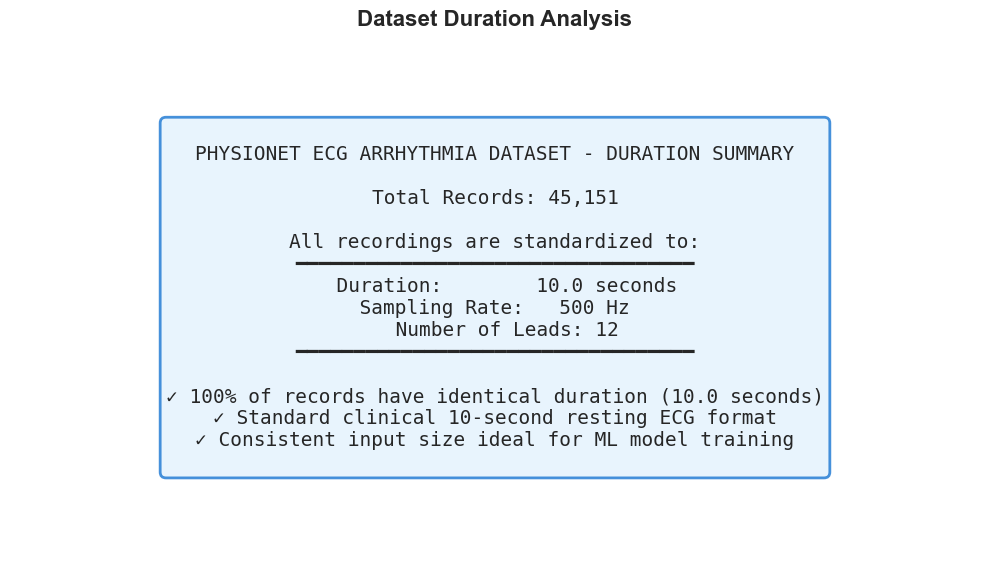

✓ Plot saved as 'duration_analysis.png'


In [ ]:
# Create duration summary visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Remove axes
ax.axis('off')

# Create summary text
summary_text = f"""
PHYSIONET ECG ARRHYTHMIA DATASET - DURATION SUMMARY

Total Records: {len(df_records):,}

All recordings are standardized to:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Duration:        10.0 seconds
  Sampling Rate:   500 Hz  
  Number of Leads: 12
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ 100% of records have identical duration (10.0 seconds)
✓ Standard clinical 10-second resting ECG format
✓ Consistent input size ideal for ML model training
"""

ax.text(0.5, 0.5, summary_text, 
        ha='center', va='center', 
        fontsize=14, 
        family='monospace',
        bbox=dict(boxstyle='round', facecolor='#e3f2fd', alpha=0.8, edgecolor='#1976d2', linewidth=2))

plt.suptitle('Dataset Duration Analysis', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.savefig('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/notebooks/plots/duration_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved as 'duration_analysis.png'")

## 4. AFib vs Normal (Sinus Rhythm) Distribution

In [17]:
# Check what SNOMED codes are actually in the dataset
all_codes = []
for codes_list in df_records['dx_codes']:
    all_codes.extend(codes_list)

# Count unique codes
from collections import Counter
code_counts = Counter(all_codes)

print("Top 20 most common SNOMED codes in dataset:")
print("=" * 60)
for code, count in code_counts.most_common(20):
    print(f"{code}: {count:,} records")

Top 20 most common SNOMED codes in dataset:
426177001: 16,559 records
426783006: 8,125 records
164890007: 8,060 records
427084000: 7,254 records
164934002: 7,043 records
55827005: 5,401 records
55930002: 4,232 records
59931005: 2,877 records
427393009: 2,550 records
164889003: 1,780 records
429622005: 1,668 records
39732003: 1,545 records
284470004: 1,312 records
10370003: 1,182 records
428750005: 1,158 records
270492004: 1,140 records
713427006: 1,096 records
427172004: 1,091 records
164917005: 1,063 records
251146004: 1,043 records


## Condtion Mapping

In [18]:
# Load the actual condition names file to create proper mapping
conditions_df = pd.read_csv('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/data/ecg-arrhythmia/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/ConditionNames_SNOMED-CT.csv')

# Display to see the mapping
print("Condition mappings:")
display(conditions_df)

# Create the proper mapping dictionary
snomed_to_name = dict(zip(conditions_df['Snomed_CT'].astype(str), conditions_df['Acronym Name']))

# Show what the top codes map to
print("\nTop codes in your dataset map to:")
top_codes = ['426177001', '426783006', '164889003', '427084000', '164934002', '55827005', '59930002', '59931005', '427393009', '164889003']
for code in top_codes[:10]:
    if code in snomed_to_name:
        print(f"{code}: {snomed_to_name[code]}")

Condition mappings:


,Acronym Name,Full Name,Snomed_CT
0,1AVB,1 degree atrioventricular block,270492004
1,2AVB,2 degree atrioventricular block,195042002
2,2AVB1,2 degree atrioventricular block(Type one),54016002
3,2AVB2,2 degree atrioventricular block(Type two),28189009
4,3AVB,3 degree atrioventricular block,27885002
...,...,...,...
58,SVT,Supraventricular Tachycardia,426761007
59,AT,Atrial Tachycardia,713422000
60,AVNRT,Atrioventricular Node Reentrant Tachycardia,233896004
61,AVRT,Atrioventricular Reentrant Tachycardia,233897008



Top codes in your dataset map to:
426177001: SB
426783006: SR
164889003: AFIB
427084000: ST
164934002: TWC
59931005: TWO
427393009: SA
164889003: AFIB


In [19]:
def categorize_rhythm(dx_codes, snomed_map):
    """
    Categorize a record based on its diagnosis codes
    Returns: 'AF', 'Normal/SR', or 'Other'
    """
    if not dx_codes:
        return 'Unknown'
    
    # Map codes to rhythm names
    rhythms = []
    for code in dx_codes:
        code_str = str(code)  # Ensure it's a string
        if code_str in snomed_map:
            rhythms.append(snomed_map[code_str])
    
    # Prioritize AF detection
    # AF codes: AFIB (Atrial Fibrillation), AFL (Atrial Flutter)
    if any(r in ['AFIB', 'AFL'] for r in rhythms):
        return 'AF'
    
    # Normal/SR codes: SR (Sinus Rhythm), SB (Sinus Bradycardia), ST (Sinus Tachycardia), SA (Sinus Arrhythmia)
    elif any(r in ['SR', 'SB', 'ST', 'SA'] for r in rhythms):
        return 'Normal/SR'
    
    # Everything else
    elif rhythms:
        return 'Other'
    else:
        return 'Unknown'

# Recreate the mapping from the conditions file
snomed_map = dict(zip(conditions_df['Snomed_CT'].astype(str), conditions_df['Acronym Name']))

# Apply categorization
df_records['rhythm_category'] = df_records['dx_codes'].apply(
    lambda x: categorize_rhythm(x, snomed_map)
)

# Count rhythms
rhythm_counts = df_records['rhythm_category'].value_counts()

print("=" * 60)
print("RHYTHM DISTRIBUTION")
print("=" * 60)
print(f"\nTotal records analyzed: {len(df_records):,}\n")
print(rhythm_counts)
print("\nPercentages:")
print(rhythm_counts / len(df_records) * 100)

# Show specific counts
af_count = rhythm_counts.get('AF', 0)
normal_count = rhythm_counts.get('Normal/SR', 0)
other_count = rhythm_counts.get('Other', 0)
unknown_count = rhythm_counts.get('Unknown', 0)

print("\n" + "=" * 60)
print("SUMMARY:")
print(f"AF records: {af_count:,} ({af_count/len(df_records)*100:.2f}%)")
print(f"Normal/SR records: {normal_count:,} ({normal_count/len(df_records)*100:.2f}%)")
print(f"Other rhythms: {other_count:,} ({other_count/len(df_records)*100:.2f}%)")
print(f"Unknown: {unknown_count:,} ({unknown_count/len(df_records)*100:.2f}%)")

RHYTHM DISTRIBUTION

Total records analyzed: 45,151

rhythm_category
Normal/SR    33558
Other         9138
AF            1780
Unknown        675
Name: count, dtype: int64

Percentages:
rhythm_category
Normal/SR    74.323935
Other        20.238754
AF            3.942327
Unknown       1.494983
Name: count, dtype: float64

SUMMARY:
AF records: 1,780 (3.94%)
Normal/SR records: 33,558 (74.32%)
Other rhythms: 9,138 (20.24%)
Unknown: 675 (1.49%)


In [20]:
# Focus on AF vs Normal
af_count = rhythm_counts.get('AF', 0)
normal_count = rhythm_counts.get('Normal/SR', 0)
other_count = len(df_records) - af_count - normal_count

print("=" * 60)
print("AF vs NORMAL DISTRIBUTION")
print("=" * 60)
print(f"\nAtrial Fibrillation (AF): {af_count:,} ({af_count/len(df_records)*100:.2f}%)")
print(f"Normal/Sinus Rhythm (SR): {normal_count:,} ({normal_count/len(df_records)*100:.2f}%)")
print(f"Other rhythms: {other_count:,} ({other_count/len(df_records)*100:.2f}%)")
print(f"\nTotal: {len(df_records):,}")

if af_count > 0 and normal_count > 0:
    ratio = normal_count / af_count
    print(f"\nClass imbalance ratio (Normal:AF) = {ratio:.2f}:1")

AF vs NORMAL DISTRIBUTION

Atrial Fibrillation (AF): 1,780 (3.94%)
Normal/Sinus Rhythm (SR): 33,558 (74.32%)
Other rhythms: 9,813 (21.73%)

Total: 45,151

Class imbalance ratio (Normal:AF) = 18.85:1


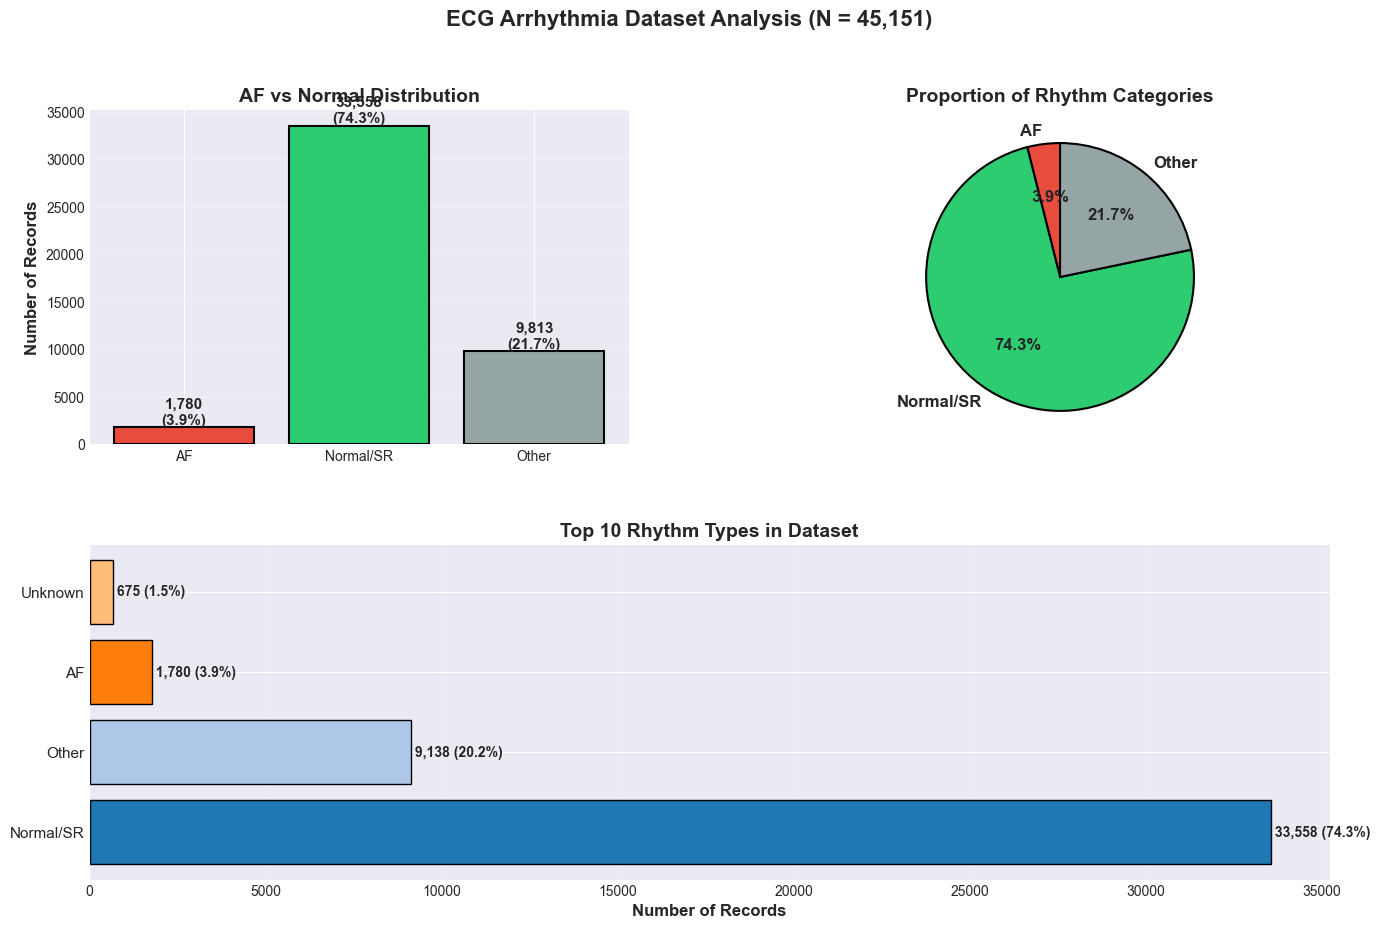

Plot saved as 'rhythm_distribution.png'


In [33]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. AF vs Normal Bar Chart
ax1 = fig.add_subplot(gs[0, 0])
categories = ['AF', 'Normal/SR', 'Other']
counts = [af_count, normal_count, other_count]
colors_bar = ['#e74c3c', '#2ecc71', '#95a5a6']
bars = ax1.bar(categories, counts, color=colors_bar, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Records', fontsize=12, fontweight='bold')
ax1.set_title('AF vs Normal Distribution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({count/len(df_records)*100:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Pie Chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(counts, labels=categories, autopct='%1.1f%%', colors=colors_bar,
        startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax2.set_title('Proportion of Rhythm Categories', fontsize=14, fontweight='bold')

# 3. All Rhythm Types (Top 10)
ax3 = fig.add_subplot(gs[1, :])
top_rhythms = rhythm_counts.head(10)
colors_rhythms = plt.cm.tab20(range(len(top_rhythms)))
bars = ax3.barh(range(len(top_rhythms)), top_rhythms.values, color=colors_rhythms,
                edgecolor='black', linewidth=1)
ax3.set_yticks(range(len(top_rhythms)))
ax3.set_yticklabels(top_rhythms.index, fontsize=11)
ax3.set_xlabel('Number of Records', fontsize=12, fontweight='bold')
ax3.set_title('Top 10 Rhythm Types in Dataset', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, count) in enumerate(zip(bars, top_rhythms.values)):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f' {count:,} ({count/len(df_records)*100:.1f}%)',
             ha='left', va='center', fontsize=10, fontweight='bold')

plt.suptitle(f'ECG Arrhythmia Dataset Analysis (N = {len(df_records):,})',
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/notebooks/plots/rhythm_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'rhythm_distribution.png'")

## 5. Sinus Rhythm (SR) ECG Visualization

Let's plot a sample 12-lead ECG with Sinus Rhythm (Normal)

In [23]:
# Find a Normal/SR record
sr_records = df_records[df_records['rhythm_category'] == 'Normal/SR']

if len(sr_records) > 0:
    # Select a random SR record
    sample_sr = sr_records.sample(1).iloc[0]
    sr_record_path = sample_sr['record_id']
    
    print(f"Selected SR record: {sr_record_path}")
    print(f"Age: {sample_sr['age']}, Gender: {sample_sr['gender']}")
    print(f"Duration: {sample_sr['duration']} seconds")
    
    # Load the actual ECG signal
    full_path = os.path.join(DATA_PATH, sr_record_path)
    record = wfdb.rdrecord(full_path)
    
    print(f"\nLoaded signal shape: {record.p_signal.shape}")
    print(f"Lead names: {record.sig_name}")
else:
    print("No SR records found!")
    record = None

Selected SR record: WFDBRecords/09/093/JS08695
Age: 39.0, Gender: Female
Duration: 10.0 seconds

Loaded signal shape: (5000, 12)
Lead names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


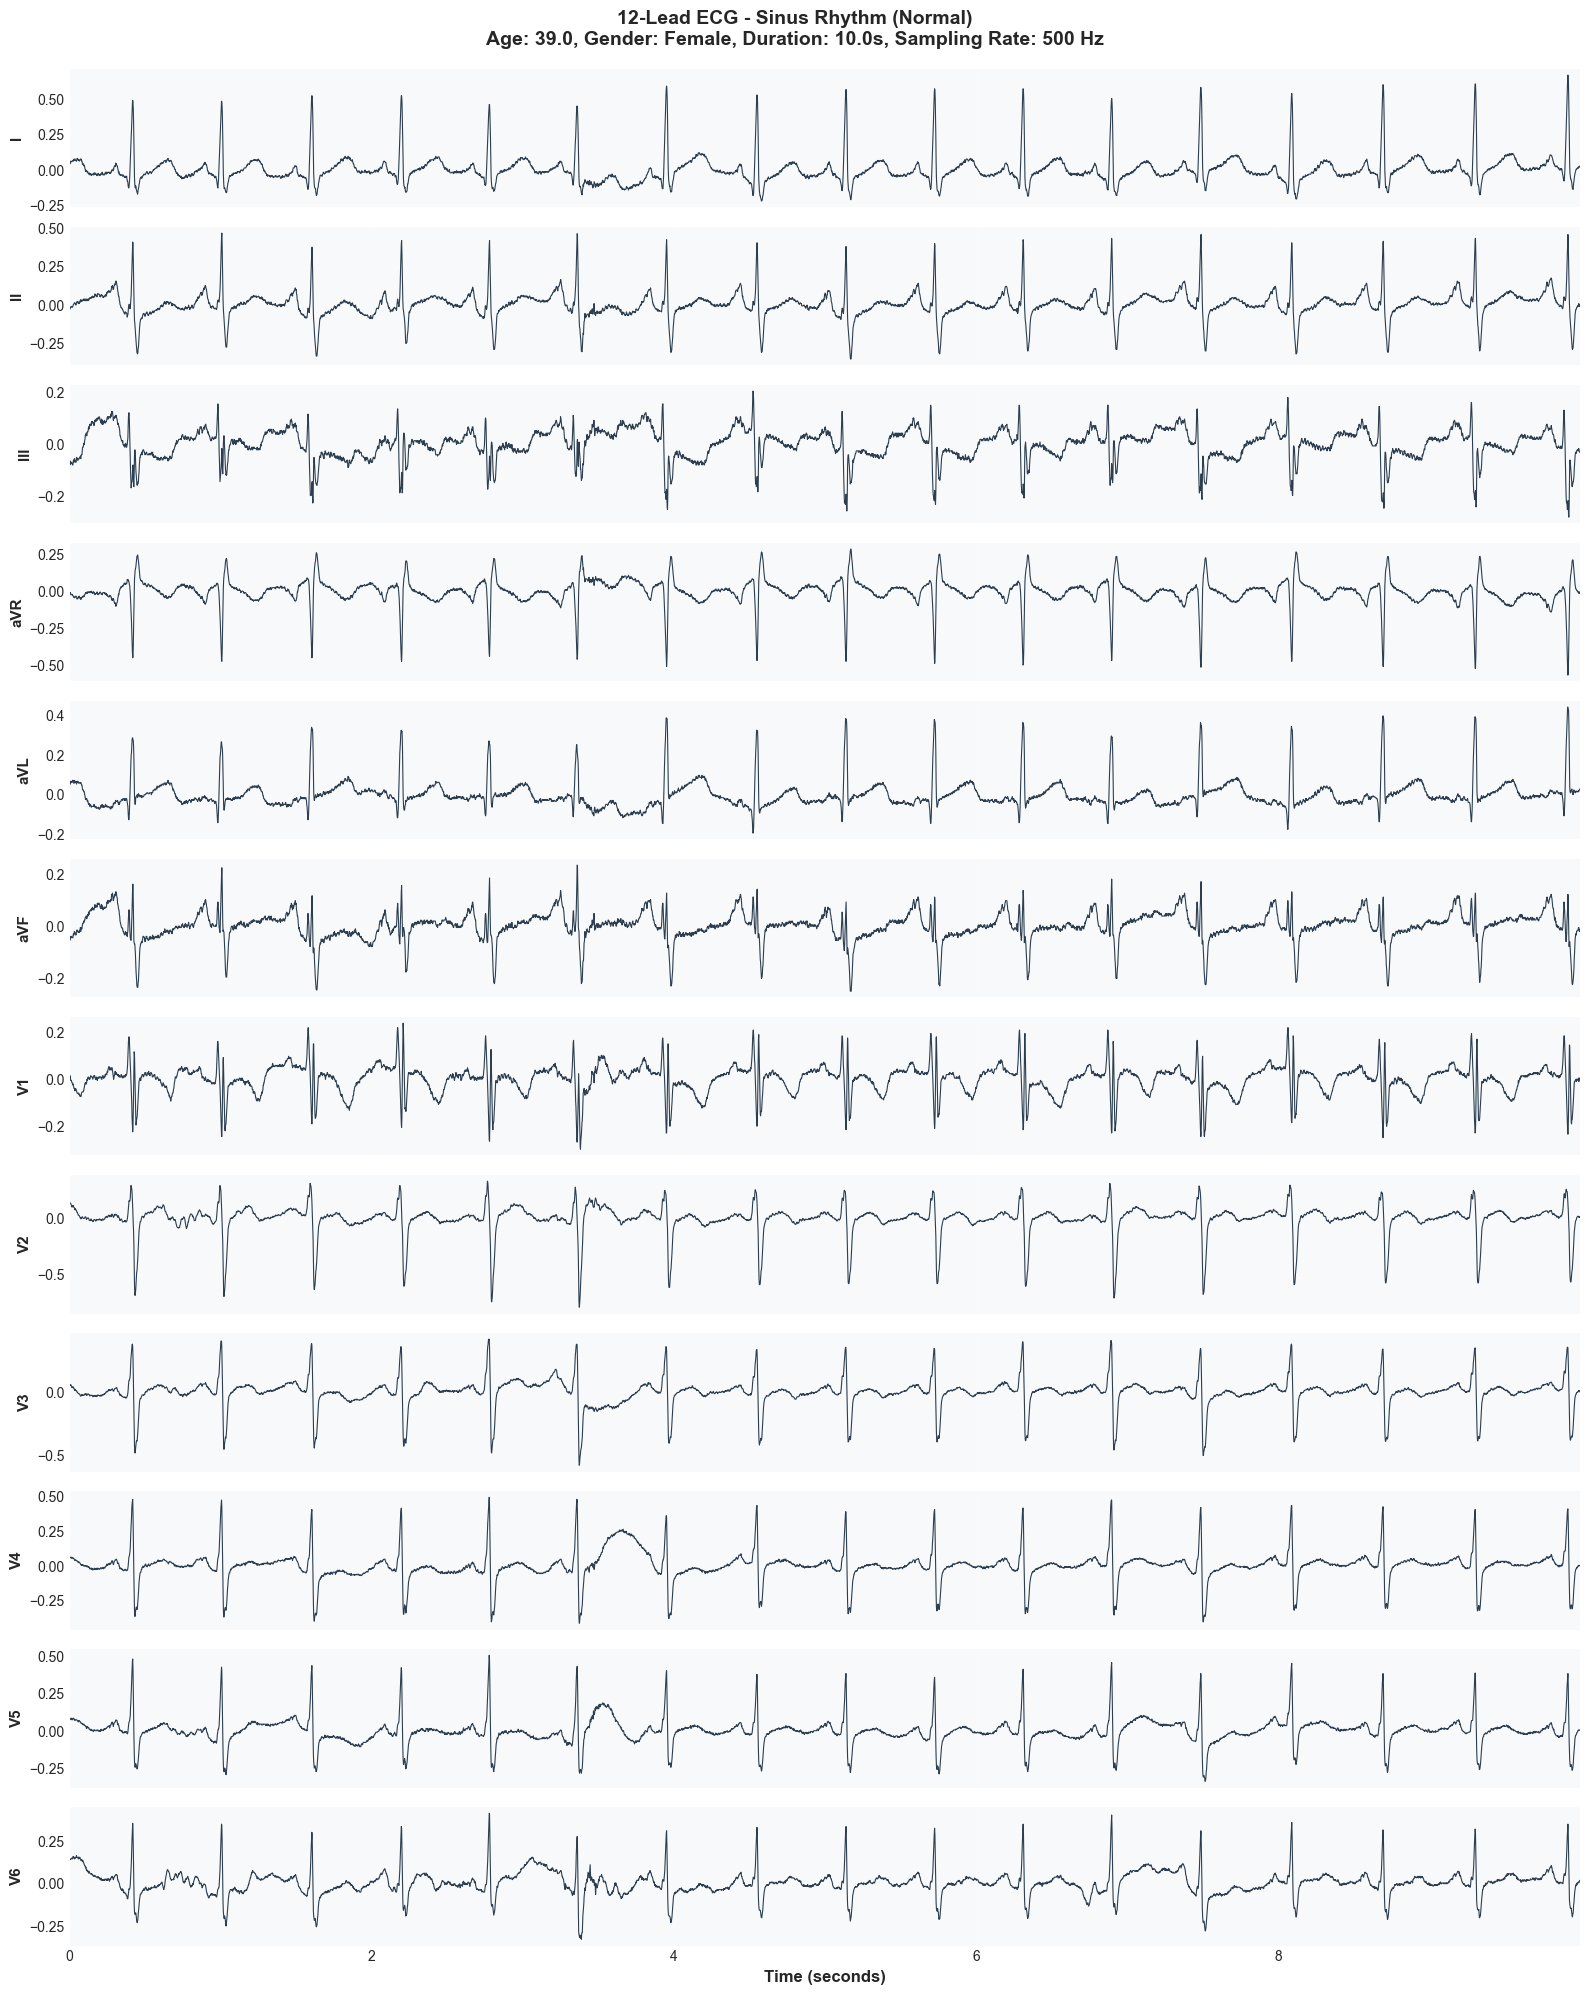

Plot saved as 'sr_ecg_12lead.png'


In [25]:
if record is not None:
    # Plot all 12 leads
    fig, axes = plt.subplots(12, 1, figsize=(16, 20), sharex=True)
    
    time = np.arange(record.sig_len) / record.fs  # Time in seconds
    
    lead_names = record.sig_name
    signals = record.p_signal
    
    for i, (ax, lead_name) in enumerate(zip(axes, lead_names)):
        ax.plot(time, signals[:, i], linewidth=0.8, color='#2c3e50')
        ax.set_ylabel(lead_name, fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, max(time)])
        
        # Add light background
        ax.set_facecolor('#f8f9fa')
    
    axes[-1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
    
    # Add title with patient info
    title = f'12-Lead ECG - Sinus Rhythm (Normal)\n'
    if sample_sr['age'] is not None:
        title += f"Age: {sample_sr['age']}, "
    if sample_sr['gender'] is not None:
        title += f"Gender: {sample_sr['gender']}, "
    title += f"Duration: {sample_sr['duration']}s, Sampling Rate: {record.fs} Hz"
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.savefig('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/notebooks/plots', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Plot saved as 'sr_ecg_12lead.png'")

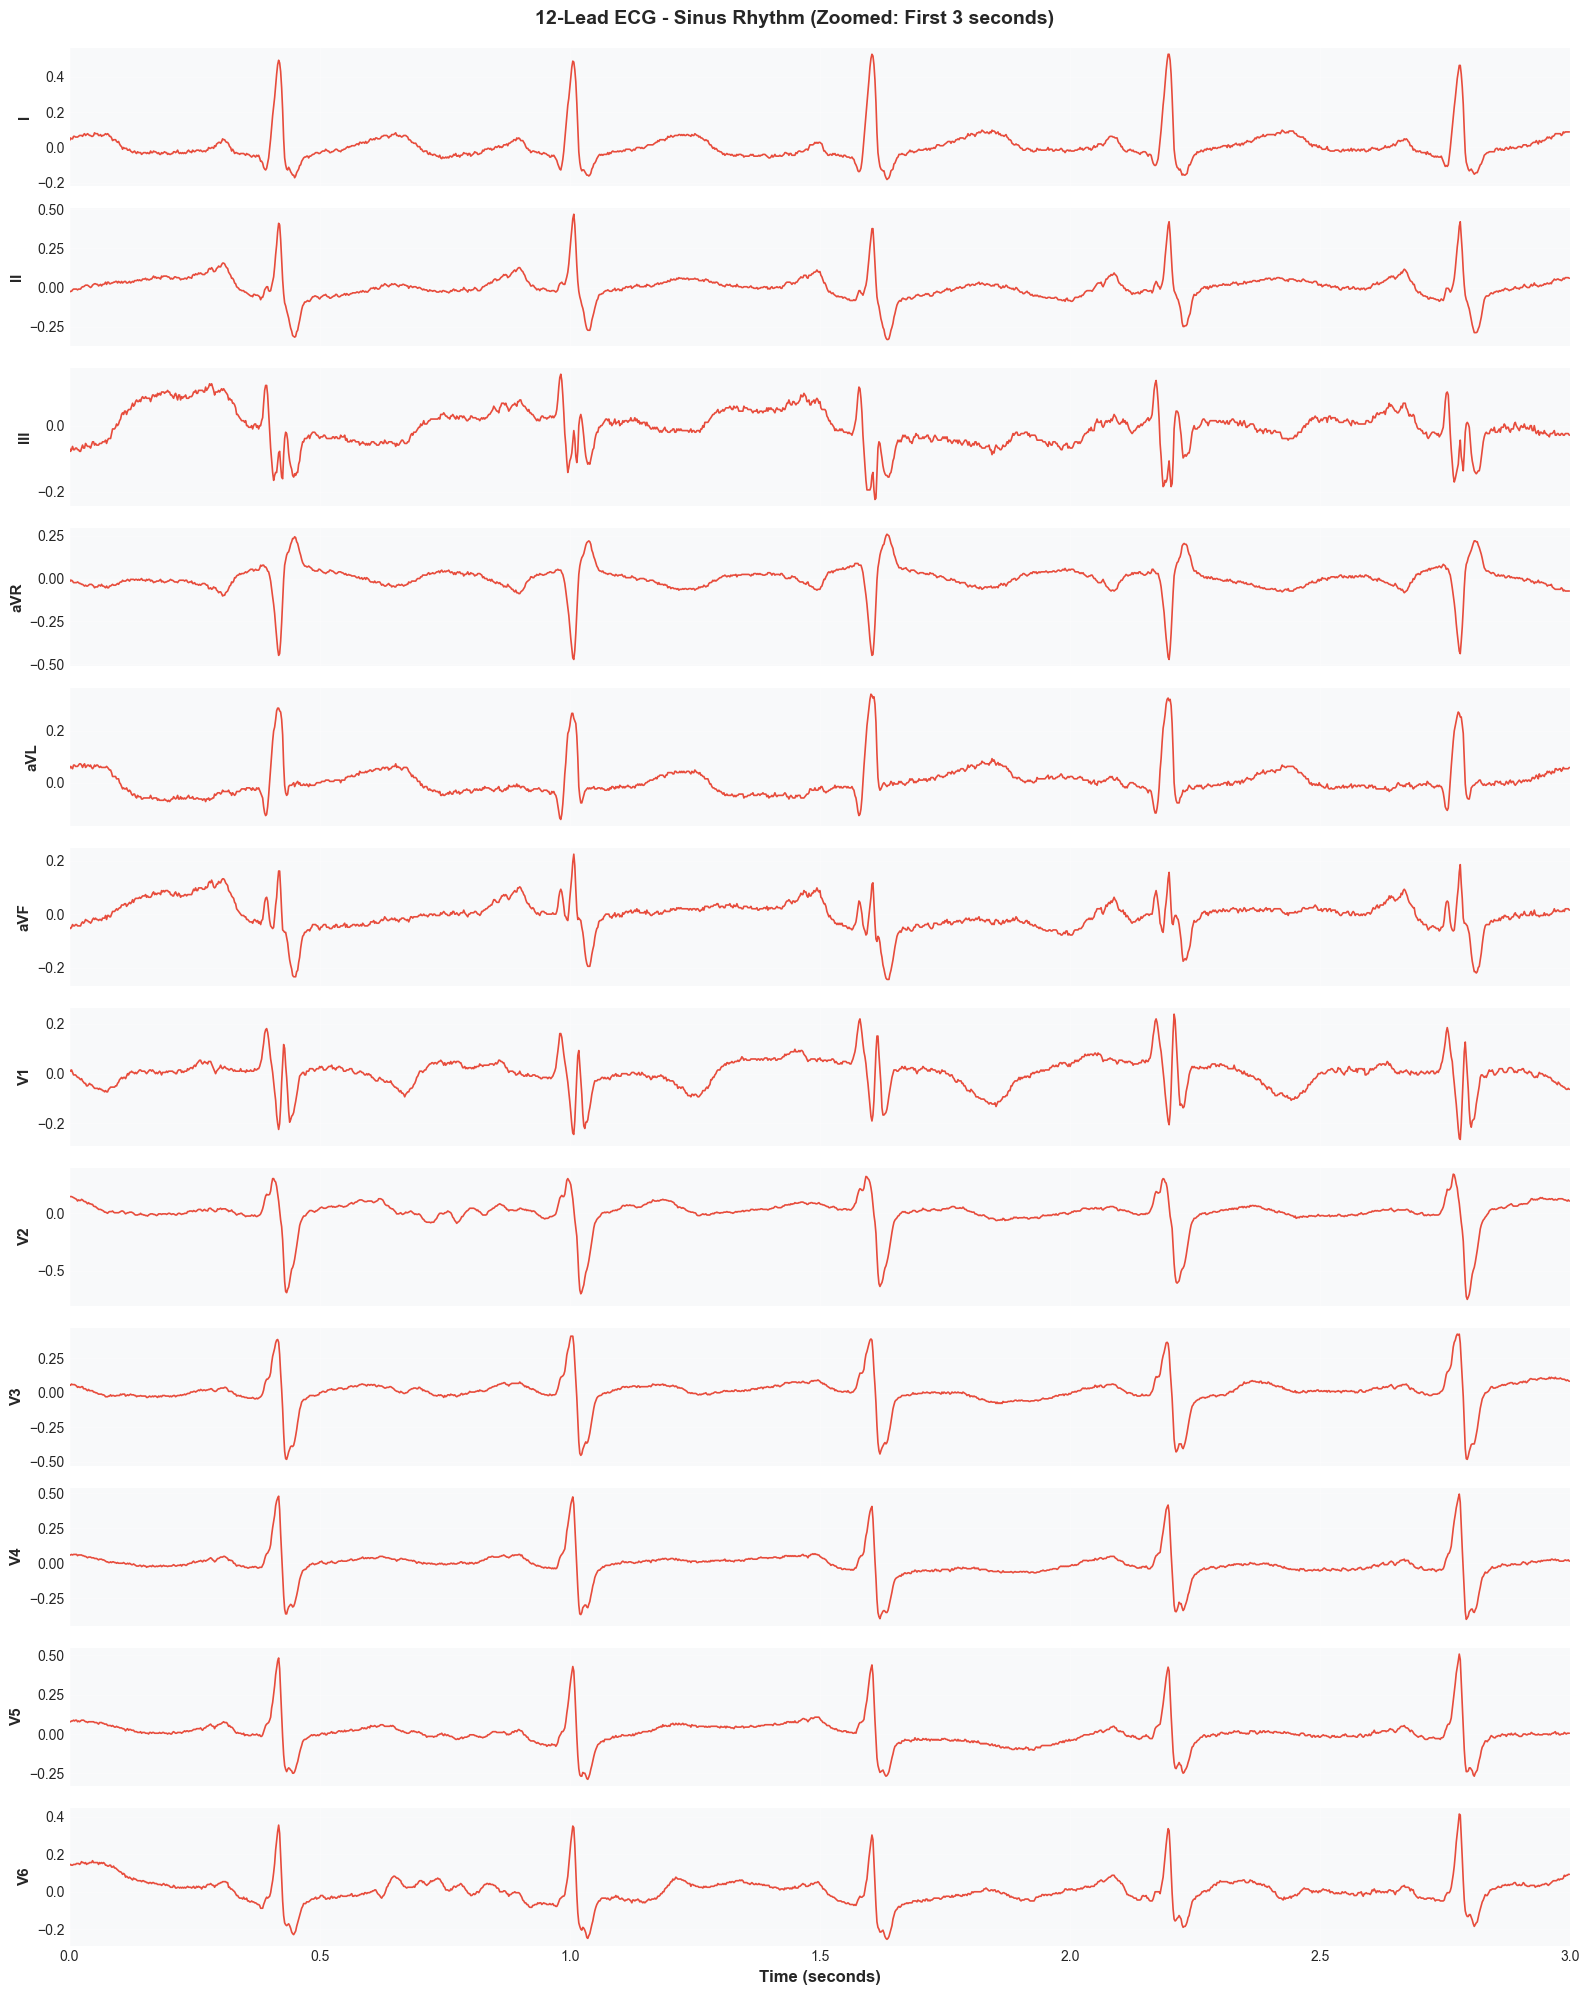

Plot saved as 'sr_ecg_zoomed.png'


In [27]:
# Plot a zoomed-in view of 2-3 seconds to see detail
if record is not None:
    fig, axes = plt.subplots(12, 1, figsize=(16, 20), sharex=True)
    
    # Show first 3 seconds
    time_window = 3  # seconds
    samples_to_show = int(time_window * record.fs)
    
    time = np.arange(samples_to_show) / record.fs
    
    for i, (ax, lead_name) in enumerate(zip(axes, lead_names)):
        ax.plot(time, signals[:samples_to_show, i], linewidth=1.2, color='#e74c3c')
        ax.set_ylabel(lead_name, fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, time_window])
        ax.set_facecolor('#f8f9fa')
    
    axes[-1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
    
    fig.suptitle(f'12-Lead ECG - Sinus Rhythm (Zoomed: First {time_window} seconds)',
                 fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.savefig('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/notebooks/plots', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Plot saved as 'sr_ecg_zoomed.png'")

## 6. Demographics Analysis

In [28]:
# Age analysis
print("=" * 60)
print("DEMOGRAPHICS ANALYSIS")
print("=" * 60)

# Overall age statistics
age_available = df_records['age'].notna().sum()
print(f"\nRecords with age information: {age_available:,} ({age_available/len(df_records)*100:.1f}%)")

if age_available > 0:
    print("\nAge Statistics:")
    print(df_records['age'].describe())

# Gender distribution
gender_counts = df_records['gender'].value_counts()
print("\nGender Distribution:")
print(gender_counts)
print("\nPercentages:")
print(gender_counts / len(df_records) * 100)

DEMOGRAPHICS ANALYSIS

Records with age information: 45,096 (99.9%)

Age Statistics:
count    45096.000000
mean        58.209509
std         19.687214
min          0.000000
25%         48.000000
50%         61.000000
75%         72.000000
max         89.000000
Name: age, dtype: float64

Gender Distribution:
gender
Male       25453
Female     19676
Unknown       22
Name: count, dtype: int64

Percentages:
gender
Male       56.373059
Female     43.578215
Unknown     0.048725
Name: count, dtype: float64


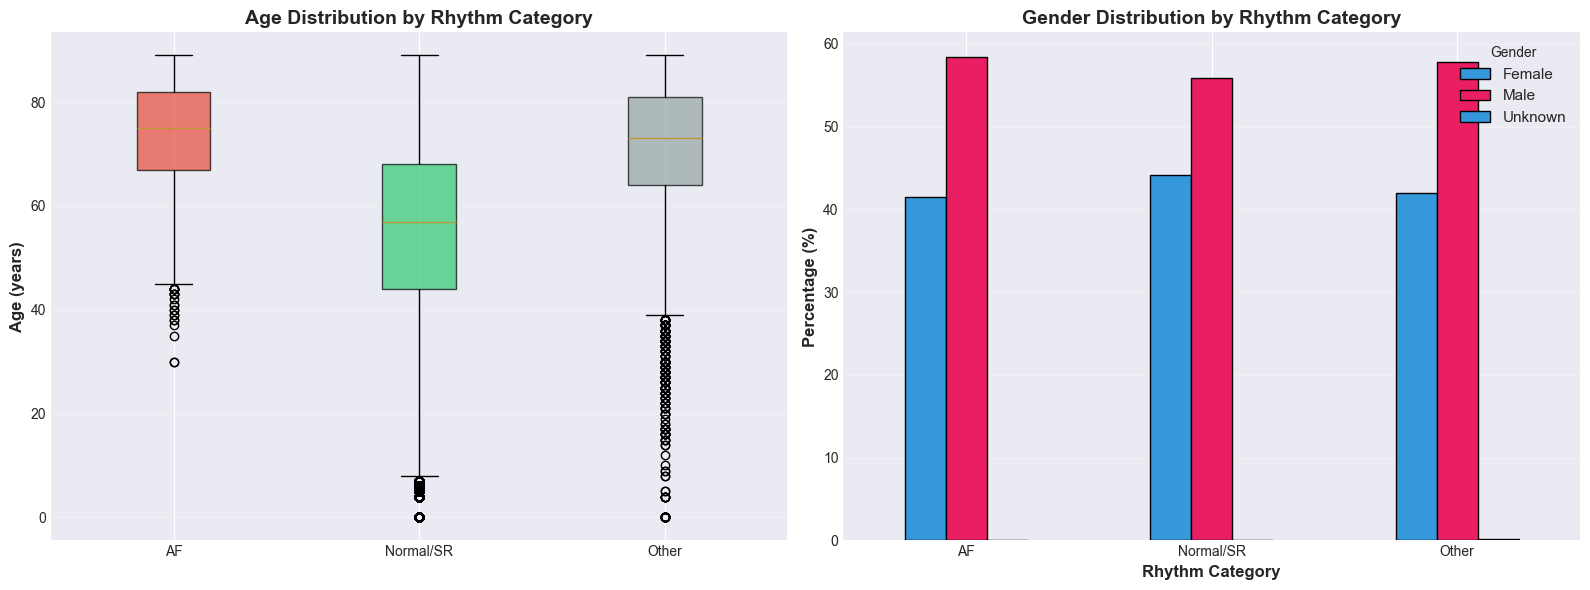

Plot saved as 'demographics_analysis.png'


In [34]:
# Age and gender by rhythm category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Age distribution by rhythm
df_with_age = df_records[df_records['age'].notna()]
rhythm_categories = ['AF', 'Normal/SR', 'Other']

age_data = [df_with_age[df_with_age['rhythm_category'] == cat]['age'].values 
            for cat in rhythm_categories]

bp = axes[0].boxplot(age_data, labels=rhythm_categories, patch_artist=True)
for patch, color in zip(bp['boxes'], ['#e74c3c', '#2ecc71', '#95a5a6']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[0].set_ylabel('Age (years)', fontsize=12, fontweight='bold')
axes[0].set_title('Age Distribution by Rhythm Category', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Gender distribution by rhythm
gender_rhythm = pd.crosstab(df_records['rhythm_category'], df_records['gender'])
gender_rhythm_pct = gender_rhythm.div(gender_rhythm.sum(axis=1), axis=0) * 100

gender_rhythm_pct.loc[rhythm_categories].plot(kind='bar', ax=axes[1], 
                                               color=['#3498db', '#e91e63'],
                                               edgecolor='black', linewidth=1)
axes[1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Rhythm Category', fontsize=12, fontweight='bold')
axes[1].set_title('Gender Distribution by Rhythm Category', fontsize=14, fontweight='bold')
axes[1].legend(title='Gender', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/notebooks/plots/demographics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'demographics_analysis.png'")

## 7. Summary Statistics Table

In [31]:
# Create summary table
summary_data = {
    'Metric': [
        'Total Records',
        'AF Records',
        'Normal/SR Records',
        'Other Rhythms',
        'Recording Duration',
        'Sampling Rate',
        'Number of Leads',
        'Mean Age',
        'Age Range',
        'Male %',
        'Female %'
    ],
    'Value': [
        f"{len(df_records):,}",
        f"{af_count:,} ({af_count/len(df_records)*100:.1f}%)",
        f"{normal_count:,} ({normal_count/len(df_records)*100:.1f}%)",
        f"{other_count:,} ({other_count/len(df_records)*100:.1f}%)",
        f"{df_records['duration'].mean():.1f} seconds",
        f"{int(df_records['sampling_rate'].mode()[0])} Hz",
        f"{int(df_records['n_leads'].mode()[0])}",
        f"{df_records['age'].mean():.1f} years" if df_records['age'].notna().sum() > 0 else "N/A",
        f"{int(df_records['age'].min())}-{int(df_records['age'].max())}" if df_records['age'].notna().sum() > 0 else "N/A",
        f"{(df_records['gender']=='Male').sum() / len(df_records) * 100:.1f}%" if 'Male' in df_records['gender'].values else "N/A",
        f"{(df_records['gender']=='Female').sum() / len(df_records) * 100:.1f}%" if 'Female' in df_records['gender'].values else "N/A"
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
display(summary_df)

# Save to CSV 
summary_df.to_csv('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/notebooks/csv/dataset_summary.csv', index=False)
print("\n✓ Summary saved as 'dataset_summary.csv'")


DATASET SUMMARY


,Metric,Value
0,Total Records,"45,151"
1,AF Records,"1,780 (3.9%)"
2,Normal/SR Records,"33,558 (74.3%)"
3,Other Rhythms,"9,813 (21.7%)"
4,Recording Duration,10.0 seconds
5,Sampling Rate,500 Hz
6,Number of Leads,12
7,Mean Age,58.2 years
8,Age Range,0-89
9,Male %,56.4%



✓ Summary saved as 'dataset_summary.csv'


## 8. Export Results

Save the processed metadata for further analysis

In [32]:
# Save the full metadata DataFrame
df_records.to_csv('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/notebooks/csv/ecg_metadata_full.csv', index=False)
print(f"Full metadata saved: {len(df_records)} records")

# Save AF vs Normal subset
df_af_normal = df_records[df_records['rhythm_category'].isin(['AF', 'Normal/SR'])]
df_af_normal.to_csv('C:/Users/Admin/OneDrive/Skrivebord/Afib-Master/notebooks/csv/ecg_metadata_af_normal.csv', index=False)
print(f"AF vs Normal subset saved: {len(df_af_normal)} records")

print("\n✓ All analyses complete!")
print("\nGenerated files:")
print("  1. duration_analysis.png")
print("  2. rhythm_distribution.png")
print("  3. sr_ecg_12lead.png")
print("  4. sr_ecg_zoomed.png")
print("  5. demographics_analysis.png")
print("  6. dataset_summary.csv")
print("  7. ecg_metadata_full.csv")
print("  8. ecg_metadata_af_normal.csv")

Full metadata saved: 45151 records
AF vs Normal subset saved: 35338 records

✓ All analyses complete!

Generated files:
  1. duration_analysis.png
  2. rhythm_distribution.png
  3. sr_ecg_12lead.png
  4. sr_ecg_zoomed.png
  5. demographics_analysis.png
  6. dataset_summary.csv
  7. ecg_metadata_full.csv
  8. ecg_metadata_af_normal.csv
